In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import re

from datetime import datetime
import numpy as np

import warnings
warnings.filterwarnings('ignore')

# 지수 표기법을 10진수로 변경
pd.set_option('display.float_format', '{:.2f}'.format)

import platform

system = platform.system()

if system == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
else:
    !apt-get -y install fonts-nanum
    !fc-cache -fv
    !rm ~/.cache/matplotlib -rf

    plt.rcParams['font.family'] = 'NanumBarunGothic'


입장 조건
* 롱 포지션:

    - 가격 > 200 SMA: 현재 가격은 200일 단순 이동 평균(SMA)보다 높아야 합니다.
    - MACD > 신호선: MACD 값이 신호선보다 높아 상승 모멘텀을 나타냅니다.
    - RSI > 50: 상대강도지수(RSI)가 50을 초과하여 강세 추세를 나타냅니다.
    - 현재 거래량 > 평균 거래량: 현재 거래량이 지난 50개 기간의 평균 거래량을 초과합니다.

* 매도 포지션:

    - 가격 < 200 SMA: 현재 가격이 200일 SMA보다 낮습니다.
    - MACD < 시그널선: MACD 값이 시그널선보다 작아 하락 모멘텀을 나타냅니다.
    - RSI < 50: RSI가 50 미만으로 약세 추세를 나타냅니다.
    - 현재 거래량 > 평균 거래량: 현재 거래량이 지난 50개 기간의 평균 거래량을 초과합니다.

종료 조건
* 롱 포지션:

    - 손절매: 진입 가격보다 낮은 특정 비율(예: 0.5% 또는 조정된 가격)로 설정합니다.
    - 전체 포지션 청산: 가격이 볼린저 밴드의 중간선에 닿을 때, 이는 추세 반전 가능성을 나타냅니다.

* 매도 포지션:

    - 손절매: 진입 가격보다 높은 특정 비율로 설정됩니다.
    - 전체 포지션 청산: 가격이 볼린저 밴드의 중간선에 닿을 때.


In [2]:
# backtest = pd.read_csv("./data/Grouped_Backtest_Results_by_Indicator.csv")
from backtest import back_testing
# from backtest_1 import back_testing
backtest = back_testing()

   Position  Entry_RSI  Exit_RSI  Max_Profit_RSI  Entry_MACD  Exit_MACD  \
0      Long      72.90     67.20           69.66       72.56      70.79   
1      Long      69.01     65.29           70.52       75.72      81.26   
2      Long      68.91     58.87           68.91       80.07      76.55   
3      Long      87.78     88.73           88.73       73.74      76.76   
4      Long      64.78     58.34           64.78       71.12      62.86   
5      Long      88.91     87.94           87.94      119.30     131.35   
6      Long      84.38     86.19           86.19      135.38     141.32   
7      Long      85.71     86.44           86.44      150.29     160.64   
8      Long      87.27     86.85           86.85      173.75     185.47   
9      Long      82.57     80.85           80.85      174.48     173.82   
10     Long      66.59     70.51           70.51      152.78     152.28   
11     Long      70.49     70.76           70.76      148.23     150.16   
12     Long      67.14   

In [3]:
backtest_long = backtest.query("Position == 'Long'")
backtest_short = backtest.query("Position == 'Short'")

In [4]:
backtest_long.describe()

,Entry_RSI,Exit_RSI,Max_Profit_RSI,Entry_MACD,Exit_MACD,Max_Profit_MACD,Entry_Signal_Line,Exit_Signal_Line,Max_Profit_Signal_Line,Entry_Bollinger_Percentage,Exit_Bollinger_Percentage,Max_Profit_Bollinger_Percentage,Entry_Price,Exit_Price,Profit_Loss,Max_Profit_Value
count,27.00,27.00,27.00,27.00,27.00,27.00,27.00,27.00,27.00,27.00,27.00,27.00,27.00,27.00,27.00,27.00
mean,73.54,72.35,74.25,130.85,133.65,136.90,119.62,123.37,124.11,82.95,78.83,82.10,63650.34,63674.18,-8.26,3.45
std,13.27,15.37,13.05,44.24,44.72,44.49,45.63,43.01,44.26,16.51,17.81,15.04,530.14,533.92,12.72,12.33
min,43.79,36.88,43.79,71.12,62.86,71.12,54.86,63.30,63.30,51.21,43.64,51.21,62659.56,62639.61,-29.18,-11.02
25%,65.69,60.68,68.03,87.89,93.31,97.29,75.68,80.37,76.79,73.13,67.78,73.03,63375.53,63386.93,-14.79,-4.53
50%,72.90,70.94,71.39,135.38,131.41,138.84,120.37,123.52,123.52,86.57,84.51,84.51,63758.99,63842.13,-10.34,0.48
75%,85.05,86.32,86.32,162.26,163.61,167.23,156.93,158.84,159.60,98.30,92.94,93.03,64109.24,64107.36,-4.32,6.50
max,95.54,100.00,95.54,216.51,224.12,224.12,191.97,192.69,191.97,109.89,101.16,101.16,64392.52,64378.66,39.99,50.81


# 숏 분석

## 테스트 중 손실
- 탈출 전략이 잘못 적용 되었다는 것을 확인할 수 있음

In [5]:
backtest_short.query("Profit_Loss < 0")

,Position,Entry_RSI,Exit_RSI,Max_Profit_RSI,Entry_MACD,Exit_MACD,Max_Profit_MACD,Entry_Signal_Line,Exit_Signal_Line,Max_Profit_Signal_Line,Entry_Bollinger_Percentage,Exit_Bollinger_Percentage,Max_Profit_Bollinger_Percentage,Entry_Time,Entry_Price,Exit_Time,Exit_Price,Profit_Loss,Max_Profit_Value,Max_Profit_Time
13,Short,34.30,33.52,34.30,-71.71,-70.01,-71.71,-50.31,-54.25,-50.31,19.02,24.07,19.02,2024-10-07 03:38:00+00:00,63441.07,2024-10-07 03:39:00+00:00,63450.66,-13.51,1.58,2024-10-07 03:38:00+00:00
14,Short,21.70,33.43,33.43,-75.92,-74.82,-74.82,-63.41,-65.69,-65.69,-7.39,16.48,16.48,2024-10-07 09:22:00+00:00,63182.35,2024-10-07 09:23:00+00:00,63245.07,-21.93,-9.39,2024-10-07 09:23:00+00:00
15,Short,34.66,39.36,25.00,-73.14,-73.12,-81.88,-67.18,-76.89,-77.42,19.21,37.84,21.27,2024-10-07 09:24:00+00:00,63244.67,2024-10-07 09:32:00+00:00,63199.89,-4.92,7.72,2024-10-07 09:30:00+00:00
30,Short,26.34,44.41,30.03,-74.57,-86.06,-84.11,-74.22,-80.51,-76.20,17.22,33.45,6.29,2024-10-07 15:15:00+00:00,63677.72,2024-10-07 15:18:00+00:00,63711.41,-17.29,10.73,2024-10-07 15:16:00+00:00
31,Short,21.15,21.12,21.15,-84.42,-87.24,-84.42,-53.40,-65.63,-53.40,11.44,22.27,11.44,2024-10-07 18:17:00+00:00,63393.58,2024-10-07 18:19:00+00:00,63420.37,-16.23,-0.61,2024-10-07 18:17:00+00:00
32,Short,38.55,42.14,38.55,-70.24,-67.57,-70.24,-58.19,-60.07,-58.19,18.28,28.54,18.28,2024-10-07 18:36:00+00:00,63308.78,2024-10-07 18:37:00+00:00,63337.70,-16.57,8.06,2024-10-07 18:36:00+00:00
35,Short,18.96,16.76,16.76,-70.15,-73.91,-73.91,-55.19,-64.32,-64.32,1.17,20.67,20.67,2024-10-07 23:57:00+00:00,62233.40,2024-10-08 00:00:00+00:00,62250.61,-14.77,-8.93,2024-10-08 00:00:00+00:00
36,Short,15.85,24.93,15.85,-85.19,-86.16,-85.19,-56.59,-62.50,-56.59,3.79,16.09,3.79,2024-10-08 07:21:00+00:00,62068.77,2024-10-08 07:22:00+00:00,62110.62,-18.75,-5.26,2024-10-08 07:21:00+00:00
37,Short,23.12,35.87,20.03,-79.89,-75.64,-84.40,-71.82,-75.98,-76.06,23.13,43.59,16.45,2024-10-08 07:25:00+00:00,62111.59,2024-10-08 07:28:00+00:00,62163.47,-20.36,2.19,2024-10-08 07:27:00+00:00


## 테스트 중 이익

In [6]:
backtest_short.query("Profit_Loss > 0")

,Position,Entry_RSI,Exit_RSI,Max_Profit_RSI,Entry_MACD,Exit_MACD,Max_Profit_MACD,Entry_Signal_Line,Exit_Signal_Line,Max_Profit_Signal_Line,Entry_Bollinger_Percentage,Exit_Bollinger_Percentage,Max_Profit_Bollinger_Percentage,Entry_Time,Entry_Price,Exit_Time,Exit_Price,Profit_Loss,Max_Profit_Value,Max_Profit_Time
33,Short,29.23,66.01,6.42,-71.87,-66.16,-160.77,-65.78,-106.32,-119.25,18.07,83.62,3.03,2024-10-07 18:43:00+00:00,63231.85,2024-10-07 19:03:00+00:00,63093.99,9.82,67.45,2024-10-07 18:51:00+00:00
34,Short,14.00,75.48,16.00,-80.82,-71.66,-193.71,-52.58,-130.46,-121.68,-21.63,74.34,-14.08,2024-10-07 22:55:00+00:00,62732.86,2024-10-07 23:14:00+00:00,62620.73,5.88,86.53,2024-10-07 23:00:00+00:00


## 정리

In [7]:
backtest_short.query("Profit_Loss < 0").describe()

,Entry_RSI,Exit_RSI,Max_Profit_RSI,Entry_MACD,Exit_MACD,Max_Profit_MACD,Entry_Signal_Line,Exit_Signal_Line,Max_Profit_Signal_Line,Entry_Bollinger_Percentage,Exit_Bollinger_Percentage,Max_Profit_Bollinger_Percentage,Entry_Price,Exit_Price,Profit_Loss,Max_Profit_Value
count,9.00,9.00,9.00,9.00,9.00,9.00,9.00,9.00,9.00,9.00,9.00,9.00,9.00,9.00,9.00,9.00
mean,26.07,32.39,26.12,-76.14,-77.17,-78.97,-61.14,-67.31,-64.24,11.76,27.00,14.85,62962.44,62987.76,-16.04,0.68
std,7.94,9.55,8.26,5.77,7.41,6.17,8.43,8.67,10.40,10.32,9.60,6.29,635.28,627.59,4.93,7.40
min,15.85,16.76,15.85,-85.19,-87.24,-85.19,-74.22,-80.51,-77.42,-7.39,16.09,3.79,62068.77,62110.62,-21.93,-9.39
25%,21.15,24.93,20.03,-79.89,-86.06,-84.40,-67.18,-75.98,-76.06,3.79,20.67,11.44,62233.40,62250.61,-18.75,-5.26
50%,23.12,33.52,25.00,-74.57,-74.82,-81.88,-58.19,-65.63,-64.32,17.22,24.07,16.48,63244.67,63245.07,-16.57,1.58
75%,34.30,39.36,33.43,-71.71,-73.12,-73.91,-55.19,-62.50,-56.59,19.02,33.45,19.02,63393.58,63420.37,-14.77,7.72
max,38.55,44.41,38.55,-70.15,-67.57,-70.24,-50.31,-54.25,-50.31,23.13,43.59,21.27,63677.72,63711.41,-4.92,10.73


In [8]:
backtest_short.query("Profit_Loss > 0").describe()

,Entry_RSI,Exit_RSI,Max_Profit_RSI,Entry_MACD,Exit_MACD,Max_Profit_MACD,Entry_Signal_Line,Exit_Signal_Line,Max_Profit_Signal_Line,Entry_Bollinger_Percentage,Exit_Bollinger_Percentage,Max_Profit_Bollinger_Percentage,Entry_Price,Exit_Price,Profit_Loss,Max_Profit_Value
count,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00
mean,21.61,70.75,11.21,-76.34,-68.91,-177.24,-59.18,-118.39,-120.46,-1.78,78.98,-5.52,62982.35,62857.36,7.85,76.99
std,10.77,6.69,6.77,6.33,3.89,23.29,9.34,17.07,1.72,28.07,6.57,12.09,352.84,334.65,2.78,13.49
min,14.00,66.01,6.42,-80.82,-71.66,-193.71,-65.78,-130.46,-121.68,-21.63,74.34,-14.08,62732.86,62620.73,5.88,67.45
25%,17.80,68.38,8.81,-78.58,-70.28,-185.47,-62.48,-124.42,-121.07,-11.70,76.66,-9.80,62857.61,62739.04,6.87,72.22
50%,21.61,70.75,11.21,-76.34,-68.91,-177.24,-59.18,-118.39,-120.46,-1.78,78.98,-5.52,62982.35,62857.36,7.85,76.99
75%,25.42,73.11,13.60,-74.11,-67.54,-169.00,-55.88,-112.36,-119.86,8.15,81.30,-1.25,63107.10,62975.68,8.83,81.76
max,29.23,75.48,16.00,-71.87,-66.16,-160.77,-52.58,-106.32,-119.25,18.07,83.62,3.03,63231.85,63093.99,9.82,86.53


# 롱

## 테스트 중 손실

In [9]:
backtest_long.query("Profit_Loss < 0")

,Position,Entry_RSI,Exit_RSI,Max_Profit_RSI,Entry_MACD,Exit_MACD,Max_Profit_MACD,Entry_Signal_Line,Exit_Signal_Line,Max_Profit_Signal_Line,Entry_Bollinger_Percentage,Exit_Bollinger_Percentage,Max_Profit_Bollinger_Percentage,Entry_Time,Entry_Price,Exit_Time,Exit_Price,Profit_Loss,Max_Profit_Value,Max_Profit_Time
0,Long,72.90,67.20,69.66,72.56,70.79,72.73,64.93,67.35,66.49,86.57,76.13,82.28,2024-10-06 14:52:00+00:00,62659.56,2024-10-06 14:54:00+00:00,62639.61,-15.18,-11.02,2024-10-06 14:53:00+00:00
1,Long,69.01,65.29,70.52,75.72,81.26,84.11,69.02,77.02,75.96,98.00,76.41,85.02,2024-10-06 14:55:00+00:00,62730.66,2024-10-06 14:59:00+00:00,62715.58,-14.40,-4.15,2024-10-06 14:58:00+00:00
2,Long,68.91,58.87,68.91,80.07,76.55,80.07,77.63,77.41,77.63,81.18,72.33,81.18,2024-10-06 15:00:00+00:00,62740.35,2024-10-06 15:01:00+00:00,62719.26,-15.36,-7.32,2024-10-06 15:00:00+00:00
3,Long,87.78,88.73,88.73,73.74,76.76,76.76,59.94,63.30,63.30,89.16,91.22,91.22,2024-10-06 16:07:00+00:00,62895.65,2024-10-06 16:08:00+00:00,62920.98,-7.98,-6.25,2024-10-06 16:08:00+00:00
4,Long,64.78,58.34,64.78,71.12,62.86,71.12,64.87,64.46,64.87,65.92,52.93,65.92,2024-10-06 16:09:00+00:00,62831.51,2024-10-06 16:10:00+00:00,62793.52,-18.04,2.23,2024-10-06 16:09:00+00:00
5,Long,88.91,87.94,87.94,119.30,131.35,131.35,59.47,73.85,73.85,100.77,93.47,93.47,2024-10-07 00:42:00+00:00,63358.43,2024-10-07 00:43:00+00:00,63353.65,-12.75,-6.42,2024-10-07 00:43:00+00:00
7,Long,85.71,86.44,86.44,150.29,160.64,160.64,114.24,123.52,123.52,86.67,87.92,87.92,2024-10-07 00:47:00+00:00,63452.61,2024-10-07 00:48:00+00:00,63515.67,-2.07,0.43,2024-10-07 00:48:00+00:00
8,Long,87.27,86.85,86.85,173.75,185.47,185.47,133.56,143.94,143.94,90.44,89.45,89.45,2024-10-07 00:49:00+00:00,63601.39,2024-10-07 00:50:00+00:00,63644.32,-5.25,5.37,2024-10-07 00:50:00+00:00
9,Long,82.57,80.85,80.85,174.48,173.82,173.82,177.92,177.10,177.10,84.39,84.51,84.51,2024-10-07 01:00:00+00:00,63761.25,2024-10-07 01:01:00+00:00,63782.70,-8.64,-8.48,2024-10-07 01:01:00+00:00
11,Long,70.49,70.76,70.76,148.23,150.16,150.16,155.08,154.10,154.10,109.89,100.22,100.22,2024-10-07 01:09:00+00:00,63944.99,2024-10-07 01:10:00+00:00,63944.59,-12.06,-7.52,2024-10-07 01:10:00+00:00


## 테스트 중 이익

In [10]:
backtest_long.query("Profit_Loss > 0")

,Position,Entry_RSI,Exit_RSI,Max_Profit_RSI,Entry_MACD,Exit_MACD,Max_Profit_MACD,Entry_Signal_Line,Exit_Signal_Line,Max_Profit_Signal_Line,Entry_Bollinger_Percentage,Exit_Bollinger_Percentage,Max_Profit_Bollinger_Percentage,Entry_Time,Entry_Price,Exit_Time,Exit_Price,Profit_Loss,Max_Profit_Value,Max_Profit_Time
6,Long,84.38,86.19,86.19,135.38,141.32,141.32,96.20,105.22,105.22,77.53,84.07,84.07,2024-10-07 00:45:00+00:00,63272.11,2024-10-07 00:46:00+00:00,63378.37,4.78,7.01,2024-10-07 00:46:00+00:00
10,Long,66.59,70.51,70.51,152.78,152.28,152.28,166.40,163.58,163.58,73.87,92.59,92.59,2024-10-07 01:05:00+00:00,63758.99,2024-10-07 01:06:00+00:00,63842.13,1.03,5.99,2024-10-07 01:06:00+00:00
19,Long,51.93,70.94,71.39,86.51,138.63,137.78,86.92,122.63,118.63,86.75,85.12,84.48,2024-10-07 14:03:00+00:00,63547.83,2024-10-07 14:16:00+00:00,63878.43,39.99,50.81,2024-10-07 14:15:00+00:00
22,Long,79.79,88.60,88.60,189.92,202.23,202.23,158.22,167.02,167.02,91.64,97.47,97.47,2024-10-07 14:21:00+00:00,64186.81,2024-10-07 14:22:00+00:00,64305.62,6.50,13.41,2024-10-07 14:22:00+00:00
25,Long,61.27,62.58,61.27,176.05,166.58,176.05,189.37,184.81,189.37,56.72,65.08,56.72,2024-10-07 14:27:00+00:00,64072.26,2024-10-07 14:28:00+00:00,64170.43,3.31,4.47,2024-10-07 14:27:00+00:00


## 정리

In [11]:
backtest_long.query("Profit_Loss < 0").describe()

,Entry_RSI,Exit_RSI,Max_Profit_RSI,Entry_MACD,Exit_MACD,Max_Profit_MACD,Entry_Signal_Line,Exit_Signal_Line,Max_Profit_Signal_Line,Entry_Bollinger_Percentage,Exit_Bollinger_Percentage,Max_Profit_Bollinger_Percentage,Entry_Price,Exit_Price,Profit_Loss,Max_Profit_Value
count,22.00,22.00,22.00,22.00,22.00,22.00,22.00,22.00,22.00,22.00,22.00,22.00,22.00,22.00,22.00,22.00
mean,74.62,71.57,73.94,126.93,127.61,131.22,115.12,117.62,118.51,84.23,77.46,81.88,63623.70,63619.44,-12.66,0.52
std,13.32,16.28,13.60,45.01,46.28,46.14,45.52,43.51,44.82,17.13,18.79,15.24,563.18,558.21,6.35,8.17
min,43.79,36.88,43.79,71.12,62.86,71.12,54.86,63.30,63.30,51.21,43.64,51.21,62659.56,62639.61,-29.18,-11.02
25%,67.58,59.29,67.58,87.83,85.03,92.42,70.20,77.12,74.37,72.81,63.85,72.67,63366.98,63364.11,-15.32,-5.92
50%,73.84,72.03,72.03,120.08,126.51,126.10,117.31,116.27,121.95,86.62,80.46,84.77,63681.32,63713.51,-12.41,-0.14
75%,86.88,86.27,86.27,150.56,160.43,160.43,153.54,149.29,153.15,98.69,92.82,92.95,64115.94,64101.00,-8.76,4.58
max,95.54,100.00,95.54,216.51,224.12,224.12,191.97,192.69,191.97,109.89,101.16,101.16,64392.52,64378.66,-2.07,20.42


In [12]:
backtest_long.query("Profit_Loss > 0").describe()

,Entry_RSI,Exit_RSI,Max_Profit_RSI,Entry_MACD,Exit_MACD,Max_Profit_MACD,Entry_Signal_Line,Exit_Signal_Line,Max_Profit_Signal_Line,Entry_Bollinger_Percentage,Exit_Bollinger_Percentage,Max_Profit_Bollinger_Percentage,Entry_Price,Exit_Price,Profit_Loss,Max_Profit_Value
count,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00
mean,68.79,75.76,75.59,148.13,160.21,161.93,139.42,148.65,148.77,77.30,84.87,83.06,63767.60,63915.00,11.12,16.34
std,13.32,11.16,11.51,40.33,25.94,27.04,45.28,33.28,35.37,13.51,12.36,15.77,374.98,357.93,16.26,19.57
min,51.93,62.58,61.27,86.51,138.63,137.78,86.92,105.22,105.22,56.72,65.08,56.72,63272.11,63378.37,1.03,4.47
25%,61.27,70.51,70.51,135.38,141.32,141.32,96.20,122.63,118.63,73.87,84.07,84.07,63547.83,63842.13,3.31,5.99
50%,66.59,70.94,71.39,152.78,152.28,152.28,158.22,163.58,163.58,77.53,85.12,84.48,63758.99,63878.43,4.78,7.01
75%,79.79,86.19,86.19,176.05,166.58,176.05,166.40,167.02,167.02,86.75,92.59,92.59,64072.26,64170.43,6.50,13.41
max,84.38,88.60,88.60,189.92,202.23,202.23,189.37,184.81,189.37,91.64,97.47,97.47,64186.81,64305.62,39.99,50.81


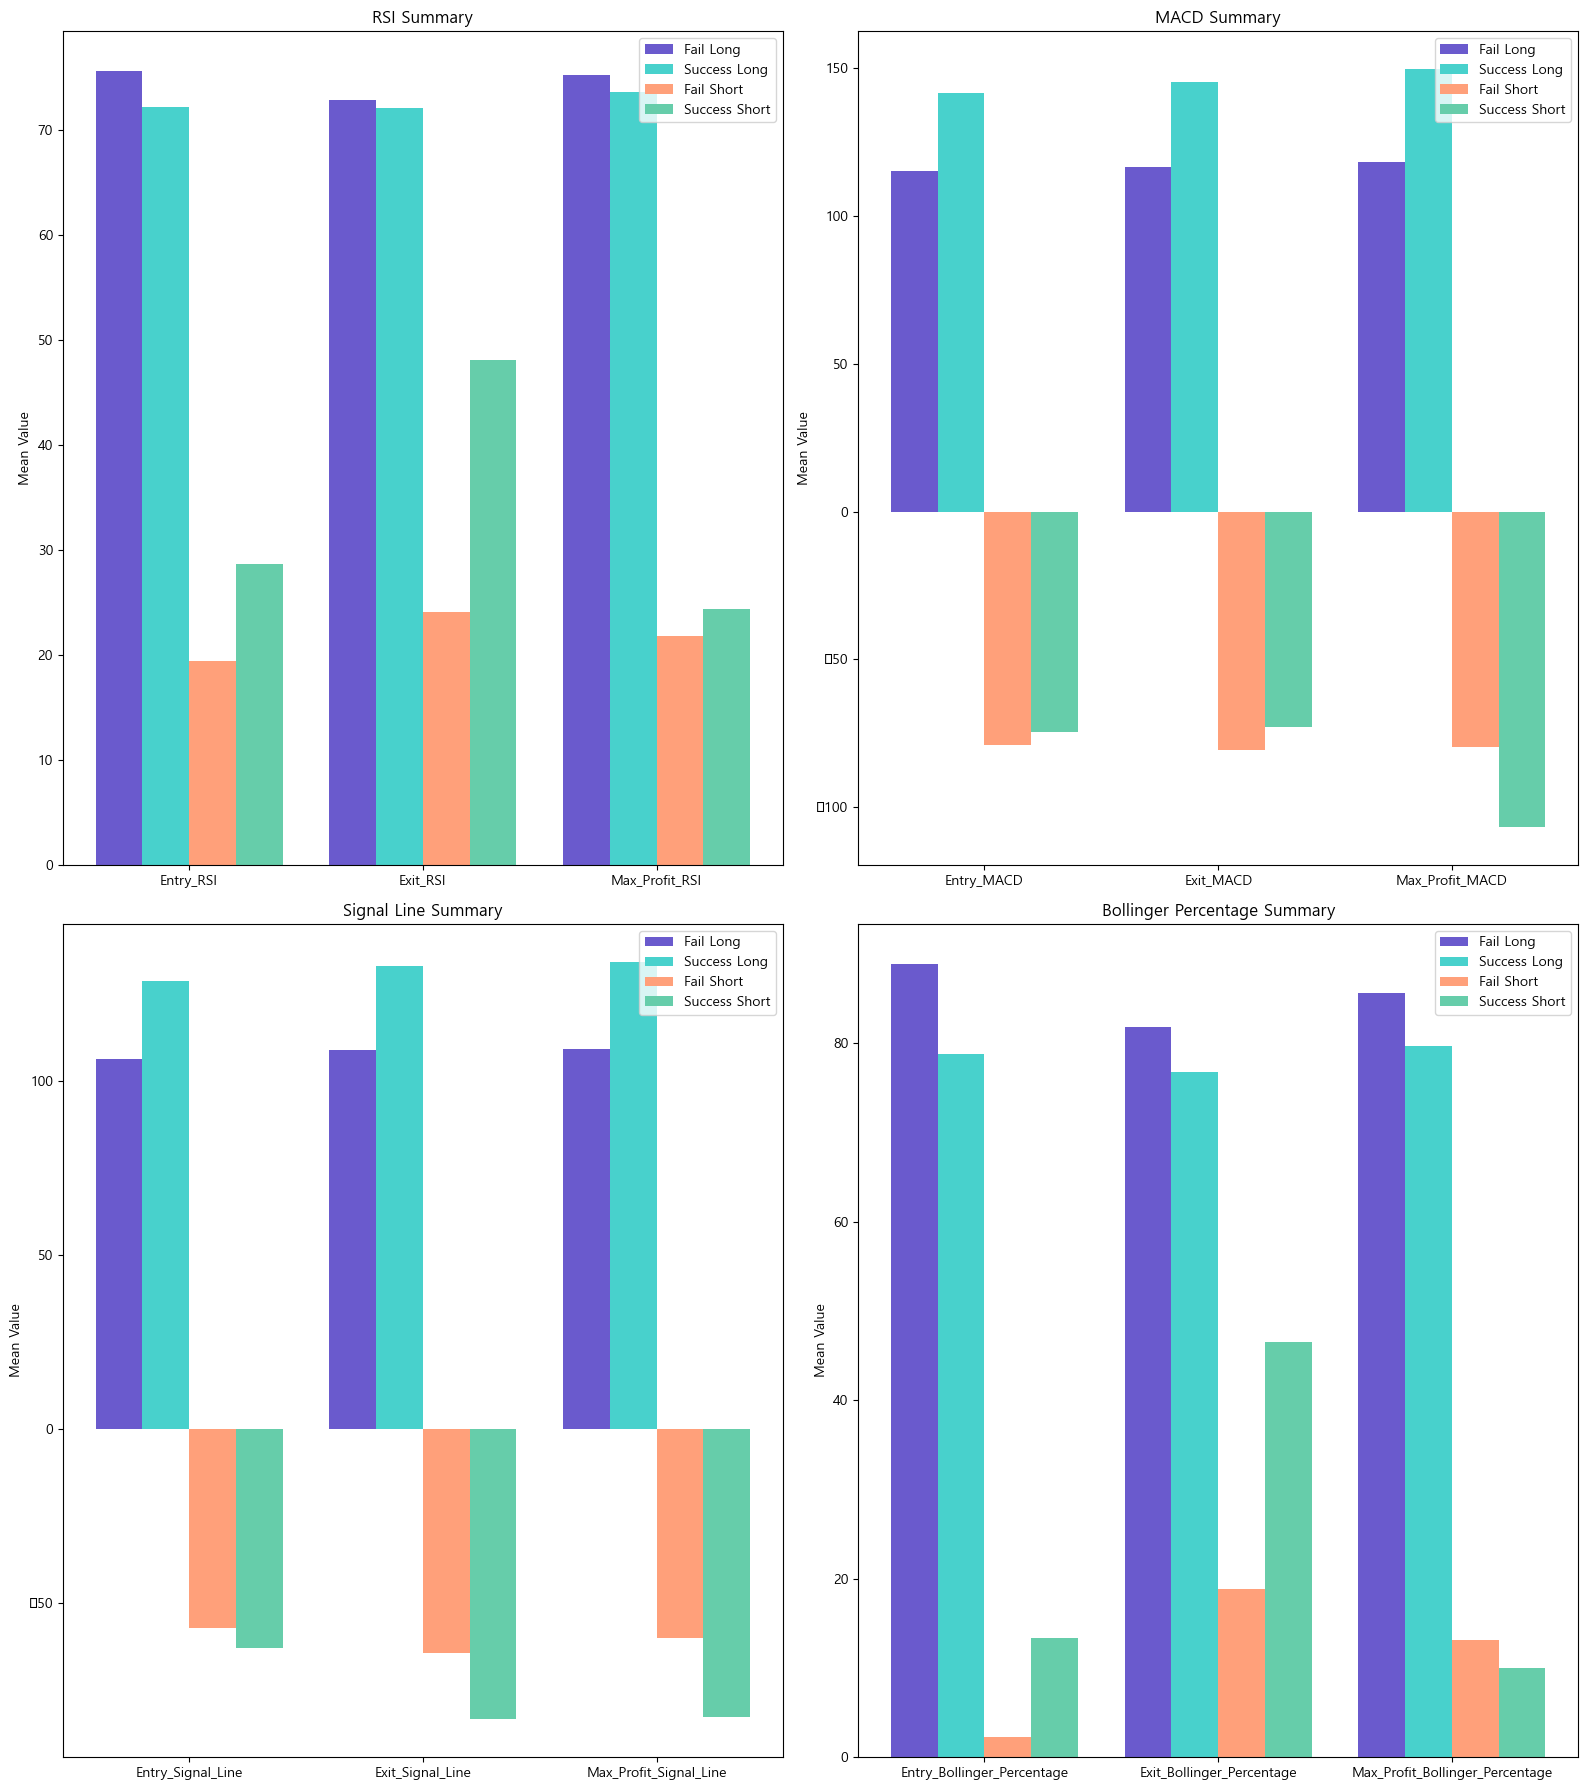

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# 성공과 실패, 롱과 숏에 대한 describe 데이터 가져오기
fail_long_desc = backtest_long.query("Max_Profit_Value < 0").describe()
success_long_desc = backtest_long.query("Max_Profit_Value > 0").describe()
fail_short_desc = backtest_short.query("Max_Profit_Value < 0").describe()
success_short_desc = backtest_short.query("Max_Profit_Value > 0").describe()

# 그래프 크기 설정
fig, axes = plt.subplots(2, 2, figsize=(16, 18))

# 각 지표별로 컬럼 묶음
rsi_columns = ['Entry_RSI', 'Exit_RSI', 'Max_Profit_RSI']
macd_columns = ['Entry_MACD', 'Exit_MACD', 'Max_Profit_MACD']
signal_columns = ['Entry_Signal_Line', 'Exit_Signal_Line', 'Max_Profit_Signal_Line']
bollinger_columns = ['Entry_Bollinger_Percentage', 'Exit_Bollinger_Percentage', 'Max_Profit_Bollinger_Percentage']

# 컬러 설정
colors = ['#6a5acd', '#48d1cc', '#ffa07a', '#66cdaa']  # 눈에 편한 색상들
bar_width = 0.2

# RSI 데이터 시각화
x = np.arange(len(rsi_columns))

axes[0, 0].bar(x - bar_width*1.5, fail_long_desc.loc['mean', rsi_columns], width=bar_width, color=colors[0], label='Fail Long')
axes[0, 0].bar(x - bar_width*0.5, success_long_desc.loc['mean', rsi_columns], width=bar_width, color=colors[1], label='Success Long')
axes[0, 0].bar(x + bar_width*0.5, fail_short_desc.loc['mean', rsi_columns], width=bar_width, color=colors[2], label='Fail Short')
axes[0, 0].bar(x + bar_width*1.5, success_short_desc.loc['mean', rsi_columns], width=bar_width, color=colors[3], label='Success Short')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(rsi_columns)
axes[0, 0].set_title("RSI Summary")
axes[0, 0].set_ylabel("Mean Value")
axes[0, 0].legend(loc='upper right')

# MACD 데이터 시각화
x = np.arange(len(macd_columns))
axes[0, 1].bar(x - bar_width*1.5, fail_long_desc.loc['mean', macd_columns], width=bar_width, color=colors[0], label='Fail Long')
axes[0, 1].bar(x - bar_width*0.5, success_long_desc.loc['mean', macd_columns], width=bar_width, color=colors[1], label='Success Long')
axes[0, 1].bar(x + bar_width*0.5, fail_short_desc.loc['mean', macd_columns], width=bar_width, color=colors[2], label='Fail Short')
axes[0, 1].bar(x + bar_width*1.5, success_short_desc.loc['mean', macd_columns], width=bar_width, color=colors[3], label='Success Short')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(macd_columns)
axes[0, 1].set_title("MACD Summary")
axes[0, 1].set_ylabel("Mean Value")
axes[0, 1].legend(loc='upper right')

# Signal Line 데이터 시각화
x = np.arange(len(signal_columns))
axes[1, 0].bar(x - bar_width*1.5, fail_long_desc.loc['mean', signal_columns], width=bar_width, color=colors[0], label='Fail Long')
axes[1, 0].bar(x - bar_width*0.5, success_long_desc.loc['mean', signal_columns], width=bar_width, color=colors[1], label='Success Long')
axes[1, 0].bar(x + bar_width*0.5, fail_short_desc.loc['mean', signal_columns], width=bar_width, color=colors[2], label='Fail Short')
axes[1, 0].bar(x + bar_width*1.5, success_short_desc.loc['mean', signal_columns], width=bar_width, color=colors[3], label='Success Short')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(signal_columns)
axes[1, 0].set_title("Signal Line Summary")
axes[1, 0].set_ylabel("Mean Value")
axes[1, 0].legend(loc='upper right')

# Bollinger Percentage 데이터 시각화
x = np.arange(len(bollinger_columns))
axes[1, 1].bar(x - bar_width*1.5, fail_long_desc.loc['mean', bollinger_columns], width=bar_width, color=colors[0], label='Fail Long')
axes[1, 1].bar(x - bar_width*0.5, success_long_desc.loc['mean', bollinger_columns], width=bar_width, color=colors[1], label='Success Long')
axes[1, 1].bar(x + bar_width*0.5, fail_short_desc.loc['mean', bollinger_columns], width=bar_width, color=colors[2], label='Fail Short')
axes[1, 1].bar(x + bar_width*1.5, success_short_desc.loc['mean', bollinger_columns], width=bar_width, color=colors[3], label='Success Short')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(bollinger_columns)
axes[1, 1].set_title("Bollinger Percentage Summary")
axes[1, 1].set_ylabel("Mean Value")
axes[1, 1].legend(loc='upper right')

# 레이아웃 조정
plt.tight_layout()
plt.show()


# 시각화

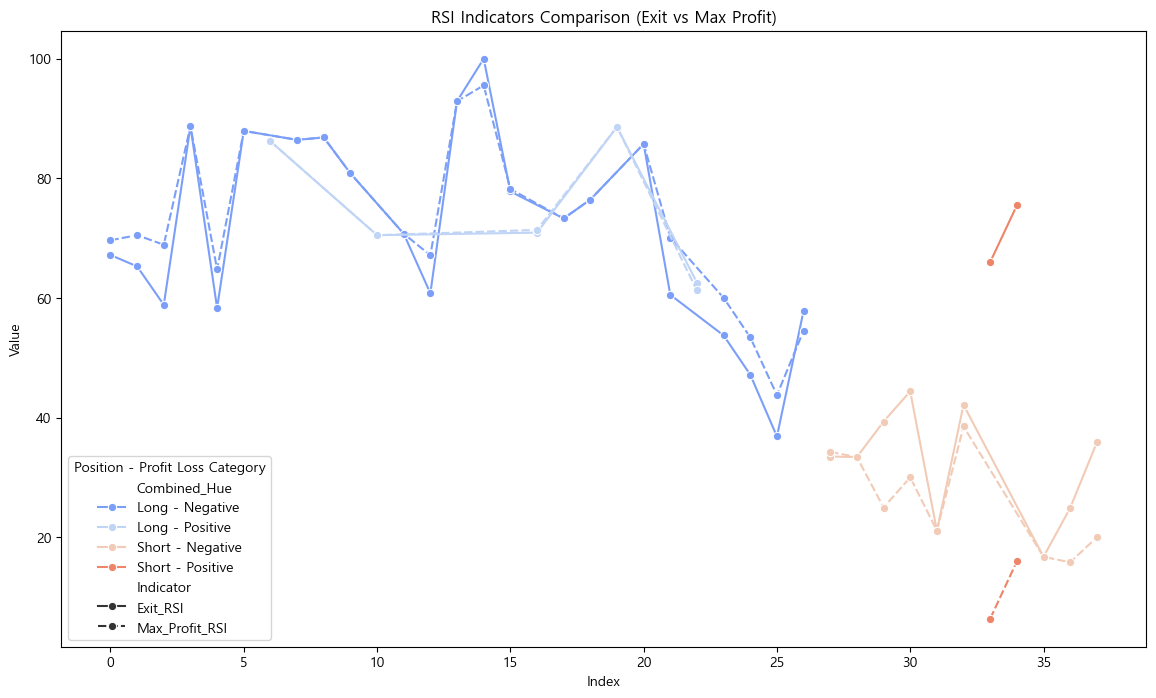

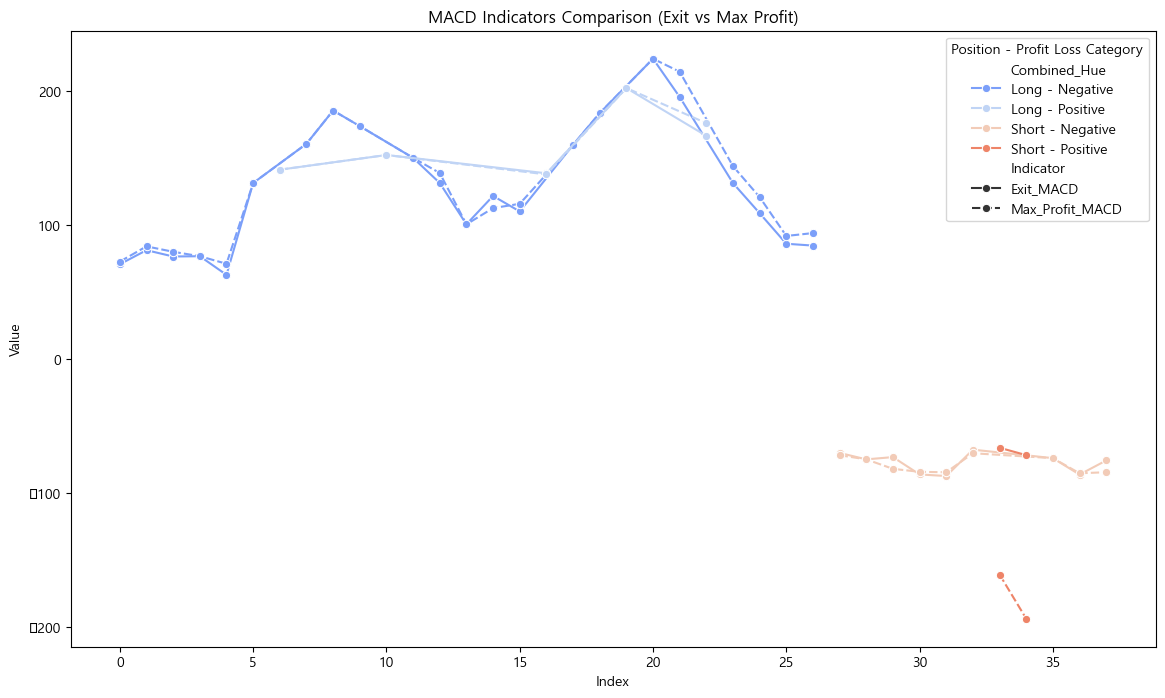

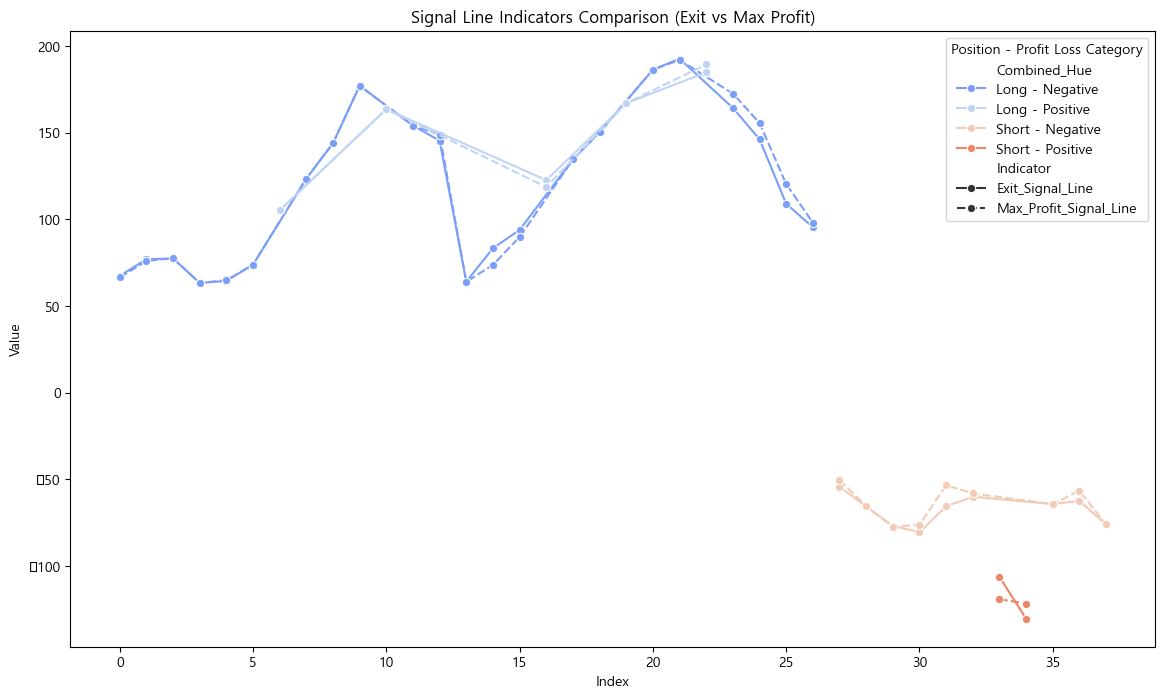

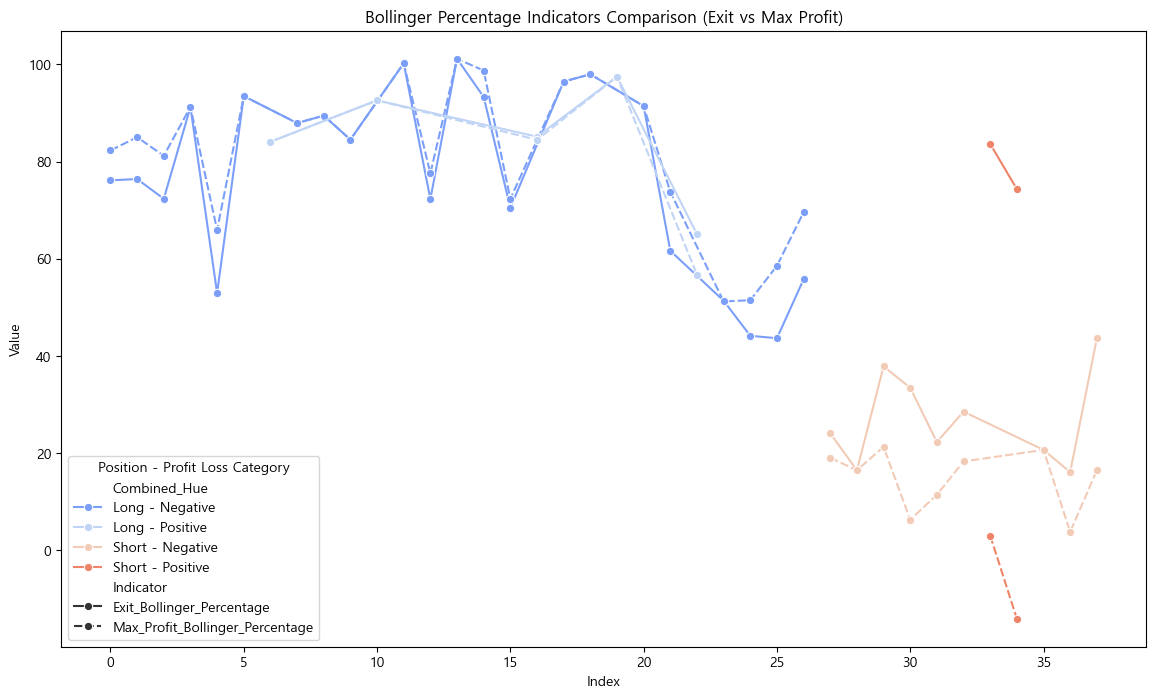

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming you have combined_data from backtest_long and backtest_short data
combined_data = pd.concat([backtest_long, backtest_short])

# Define indicator groups
exit_indicators = ["Exit_RSI", "Exit_MACD", "Exit_Signal_Line", "Exit_Bollinger_Percentage"]
max_profit_indicators = ["Max_Profit_RSI", "Max_Profit_MACD", "Max_Profit_Signal_Line", "Max_Profit_Bollinger_Percentage"]

# Melt the data
plot_data = combined_data.melt(id_vars=["Position", "Profit_Loss"], 
                               value_vars=exit_indicators + max_profit_indicators,
                               var_name="Indicator", value_name="Value")

# Create a combined hue for Position and Profit_Loss
plot_data["Profit_Loss_Category"] = plot_data["Profit_Loss"].apply(lambda x: "Positive" if x > 0 else "Negative")
plot_data["Combined_Hue"] = plot_data["Position"] + " - " + plot_data["Profit_Loss_Category"]

# Add a numeric index column for x-axis, grouped by each Indicator
plot_data["Index"] = plot_data.groupby("Indicator").cumcount()

# Plot RSI indicators
plt.figure(figsize=(14, 8))
sns.lineplot(data=plot_data[plot_data["Indicator"].isin(["Exit_RSI", "Max_Profit_RSI"])],
             x="Index", y="Value", hue="Combined_Hue", style="Indicator", marker="o", palette="coolwarm")
plt.title("RSI Indicators Comparison (Exit vs Max Profit)")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend(title="Position - Profit Loss Category")
plt.show()

# Plot MACD indicators
plt.figure(figsize=(14, 8))
sns.lineplot(data=plot_data[plot_data["Indicator"].isin(["Exit_MACD", "Max_Profit_MACD"])],
             x="Index", y="Value", hue="Combined_Hue", style="Indicator", marker="o", palette="coolwarm")
plt.title("MACD Indicators Comparison (Exit vs Max Profit)")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend(title="Position - Profit Loss Category")
plt.show()

# Plot Signal Line indicators
plt.figure(figsize=(14, 8))
sns.lineplot(data=plot_data[plot_data["Indicator"].isin(["Exit_Signal_Line", "Max_Profit_Signal_Line"])],
             x="Index", y="Value", hue="Combined_Hue", style="Indicator", marker="o", palette="coolwarm")
plt.title("Signal Line Indicators Comparison (Exit vs Max Profit)")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend(title="Position - Profit Loss Category")
plt.show()

# Plot Bollinger Percentage indicators
plt.figure(figsize=(14, 8))
sns.lineplot(data=plot_data[plot_data["Indicator"].isin(["Exit_Bollinger_Percentage", "Max_Profit_Bollinger_Percentage"])],
             x="Index", y="Value", hue="Combined_Hue", style="Indicator", marker="o", palette="coolwarm")
plt.title("Bollinger Percentage Indicators Comparison (Exit vs Max Profit)")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend(title="Position - Profit Loss Category")
plt.show()


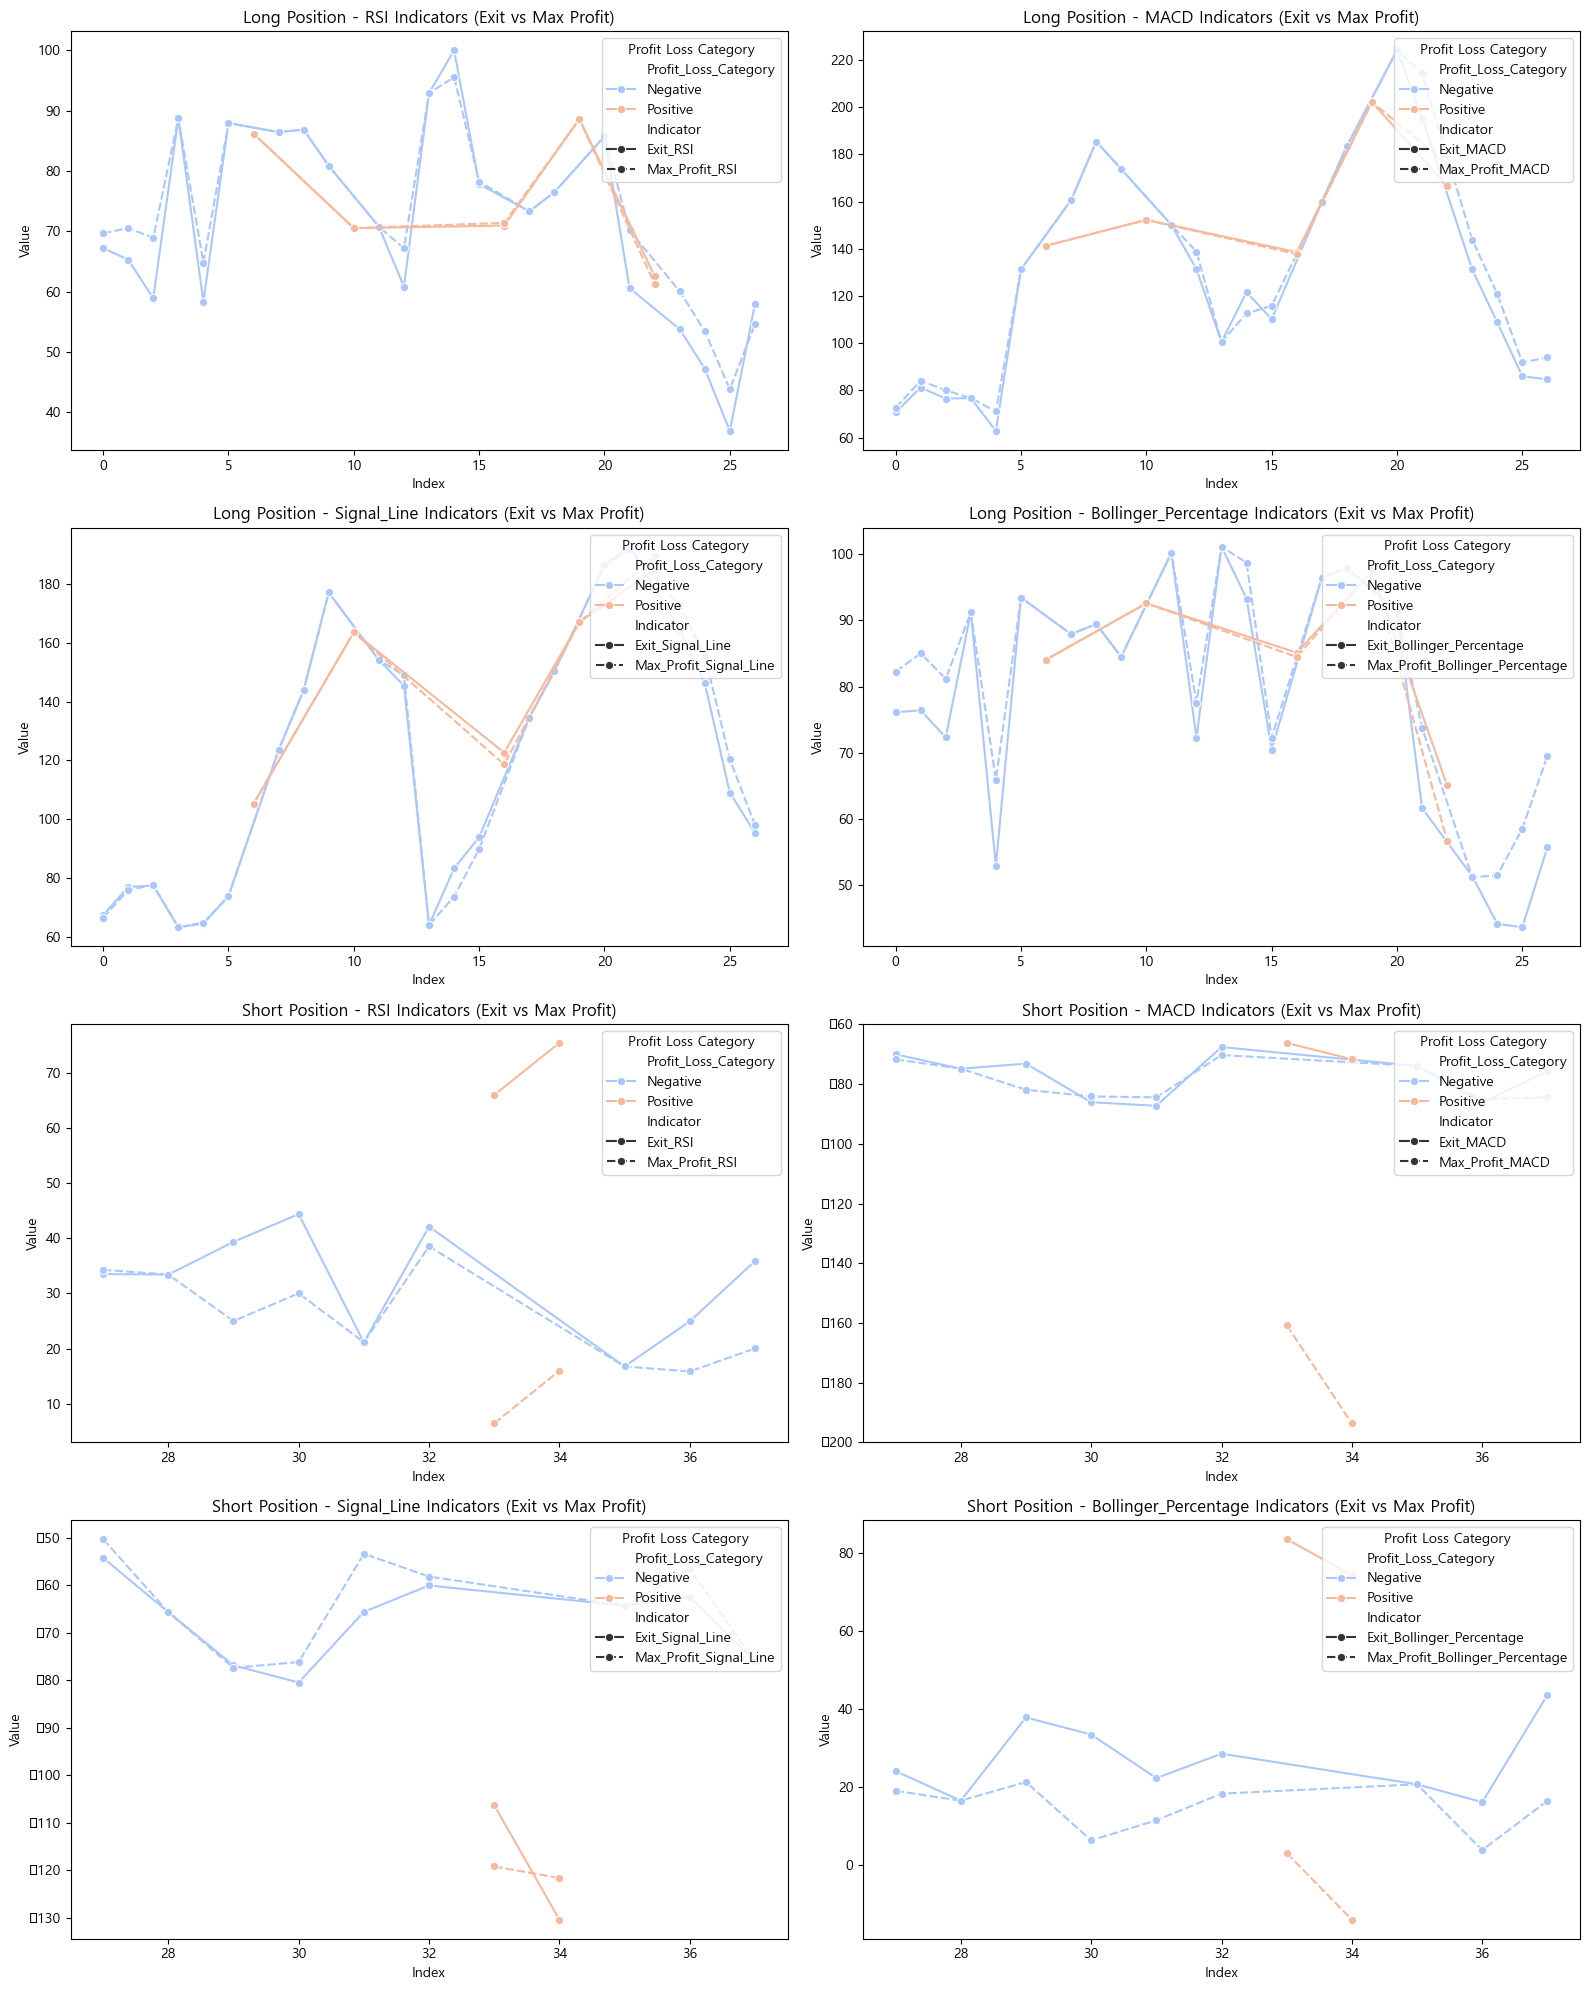

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming combined_data is your concatenated dataframe of backtest_long and backtest_short
# combined_data = pd.concat([backtest_long, backtest_short])

# Define indicator groups
exit_indicators = ["Exit_RSI", "Exit_MACD", "Exit_Signal_Line", "Exit_Bollinger_Percentage"]
max_profit_indicators = ["Max_Profit_RSI", "Max_Profit_MACD", "Max_Profit_Signal_Line", "Max_Profit_Bollinger_Percentage"]

# Melt the data
plot_data = combined_data.melt(id_vars=["Position", "Profit_Loss"], 
                               value_vars=exit_indicators + max_profit_indicators,
                               var_name="Indicator", value_name="Value")

# Create a combined hue for Profit_Loss
plot_data["Profit_Loss_Category"] = plot_data["Profit_Loss"].apply(lambda x: "Positive" if x > 0 else "Negative")

# Add a numeric index column for x-axis, grouped by each Indicator
plot_data["Index"] = plot_data.groupby("Indicator").cumcount()

# Plot setup for 8 graphs
plt.figure(figsize=(16, 20))
positions = ["Long", "Short"]
indicators = ["RSI", "MACD", "Signal_Line", "Bollinger_Percentage"]
indicator_pairs = {
    "RSI": ["Exit_RSI", "Max_Profit_RSI"],
    "MACD": ["Exit_MACD", "Max_Profit_MACD"],
    "Signal_Line": ["Exit_Signal_Line", "Max_Profit_Signal_Line"],
    "Bollinger_Percentage": ["Exit_Bollinger_Percentage", "Max_Profit_Bollinger_Percentage"]
}

# Loop through positions and indicators
for pos_idx, pos in enumerate(positions):
    for ind_idx, ind in enumerate(indicators):
        plt.subplot(4, 2, pos_idx * 4 + ind_idx + 1)
        
        # Filter data based on Position and specific indicator pair
        data = plot_data[(plot_data["Position"] == pos) & 
                         (plot_data["Indicator"].isin(indicator_pairs[ind]))]
        
        # Create line plot for the filtered data
        sns.lineplot(data=data, x="Index", y="Value", 
                     hue="Profit_Loss_Category", style="Indicator", marker="o", palette="coolwarm")
        plt.title(f"{pos} Position - {ind} Indicators (Exit vs Max Profit)")
        plt.xlabel("Index")
        plt.ylabel("Value")
        plt.legend(title="Profit Loss Category", loc='upper right')

plt.tight_layout()
plt.show()


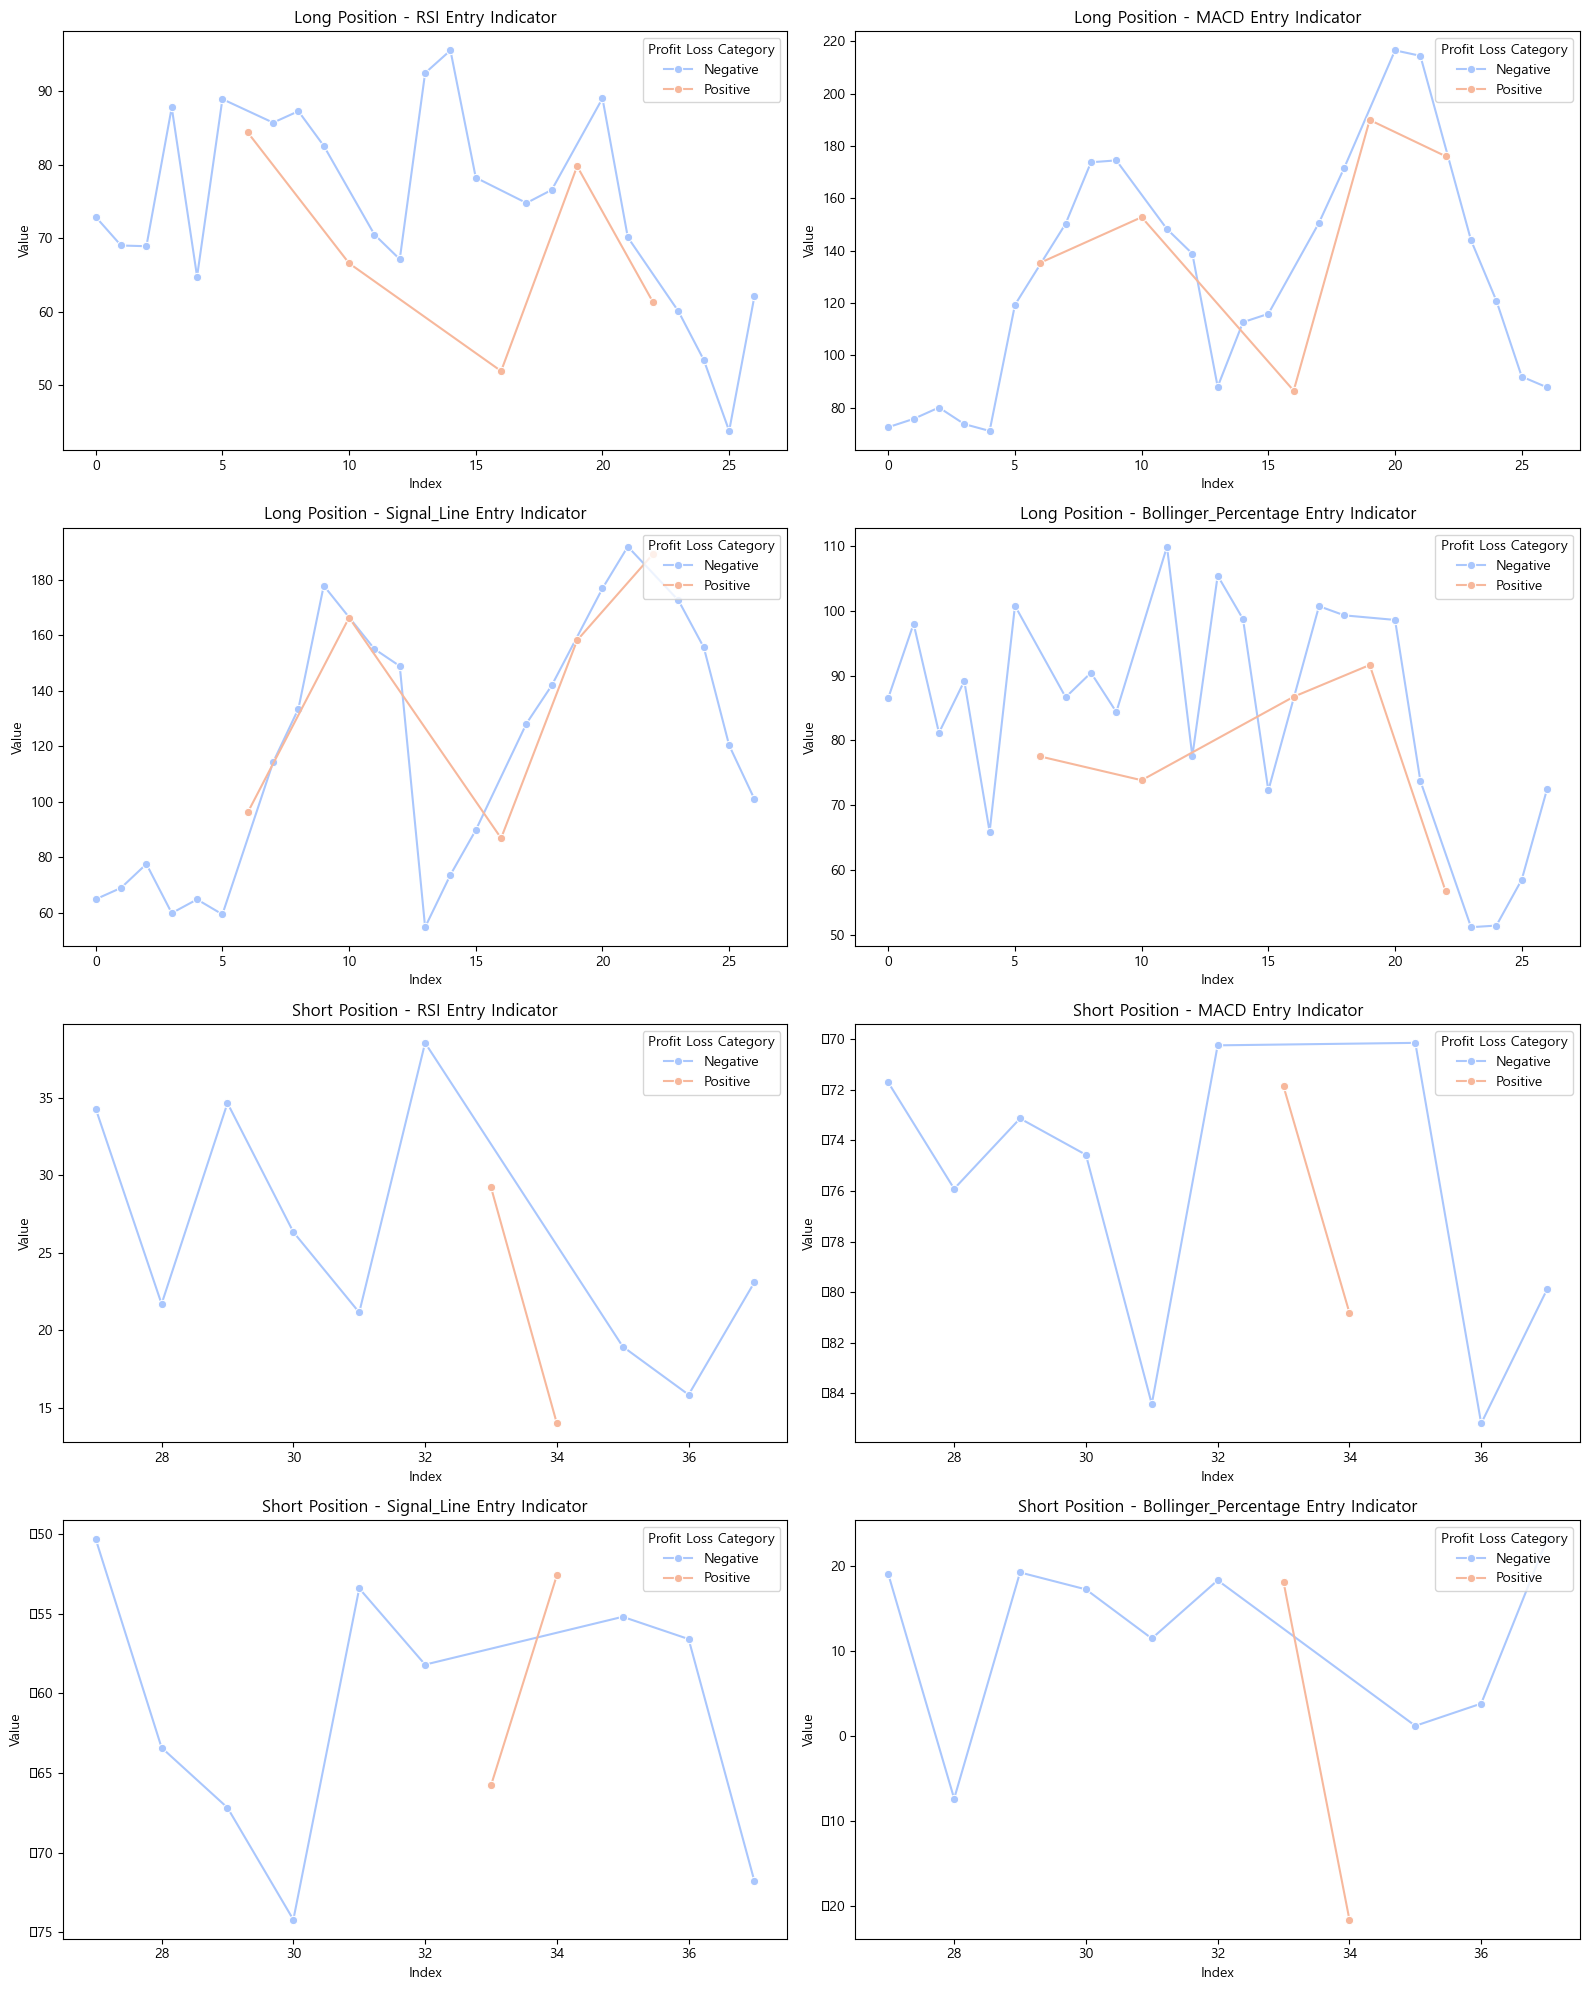

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming combined_data is your concatenated dataframe of backtest_long and backtest_short
# combined_data = pd.concat([backtest_long, backtest_short])

# Define indicator groups for entry, exit, and max profit
entry_indicators = ["Entry_RSI", "Entry_MACD", "Entry_Signal_Line", "Entry_Bollinger_Percentage"]

# Melt the data to include entry indicators
plot_data = combined_data.melt(id_vars=["Position", "Profit_Loss"], 
                               value_vars=entry_indicators,
                               var_name="Indicator", value_name="Value")

# Create a combined hue for Profit_Loss
plot_data["Profit_Loss_Category"] = plot_data["Profit_Loss"].apply(lambda x: "Positive" if x > 0 else "Negative")

# Add a numeric index column for x-axis, grouped by each Indicator
plot_data["Index"] = plot_data.groupby("Indicator").cumcount()

# Plot setup for 4 graphs (Long and Short positions separated for each indicator)
plt.figure(figsize=(16, 20))
positions = ["Long", "Short"]
indicators = ["RSI", "MACD", "Signal_Line", "Bollinger_Percentage"]
indicator_pairs_entry = {
    "RSI": ["Entry_RSI"],
    "MACD": ["Entry_MACD"],
    "Signal_Line": ["Entry_Signal_Line"],
    "Bollinger_Percentage": ["Entry_Bollinger_Percentage"]
}

# Loop through positions and entry indicators
for pos_idx, pos in enumerate(positions):
    for ind_idx, ind in enumerate(indicators):
        plt.subplot(4, 2, pos_idx * 4 + ind_idx + 1)
        
        # Filter data based on Position and specific entry indicator
        data = plot_data[(plot_data["Position"] == pos) & 
                         (plot_data["Indicator"].isin(indicator_pairs_entry[ind]))]
        
        # Create line plot for the filtered data
        sns.lineplot(data=data, x="Index", y="Value", 
                     hue="Profit_Loss_Category", marker="o", palette="coolwarm")
        plt.title(f"{pos} Position - {ind} Entry Indicator")
        plt.xlabel("Index")
        plt.ylabel("Value")
        plt.legend(title="Profit Loss Category", loc='upper right')

plt.tight_layout()
plt.show()
